# Character Mentions (POV) — First half / Second half / Total

This notebook computes **character mention counts** for long novels (e.g., *War and Peace*, *Anna Karenina*).
It reports counts for the **first half**, **second half**, and **the whole book**, and visualizes results with
unique charts (slope chart + donut). The notebook is written to be robust and well-documented: each code cell
is followed by a markdown cell explaining what it does.

**Notes:**
- Designed to run with Python 3.11 and packages in your `requirements.txt` (uses `nltk`, `pandas`, `matplotlib`).
- The notebook auto-detects `.txt` files in `../data/` and will use them; edit `book_path` in the first code cell
  if you want to analyze a different file.


In [1]:
# Imports and setup (safe, part of requirements)
import os, re, math, collections, itertools
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize

# Helper: data directory and automatic detection of .txt files
data_dir = os.path.join('..', 'data')
txt_files = []
if os.path.exists(data_dir):
    txt_files = sorted([f for f in os.listdir(data_dir) if f.lower().endswith('.txt')])
print('Data directory:', data_dir)
print('Found text files:', txt_files)

# You may change this to a specific file name from the list above
# Example: book_file = 'War_and_Peace.txt'
book_file = txt_files[0] if txt_files else None
book_path = os.path.join(data_dir, book_file) if book_file else None
print('Selected book:', book_file)


Data directory: ..\data
Found text files: ['The Project Gutenberg eBook of Anna Karenina, by Leo Tolstoy.txt', 'The Project Gutenberg eBook of War and Peace, by Leo Tolstoy.txt']
Selected book: The Project Gutenberg eBook of Anna Karenina, by Leo Tolstoy.txt


**What this cell does:**

- Imports necessary libraries (`nltk`, `pandas`, `matplotlib`, and Python stdlib).
- Ensures the NLTK sentence tokenizer (`punkt`) is available.
- Detects `.txt` files in `../data/` and selects the first one by default. Edit `book_file` if you want a different file.

**Why:** This centralises setup and makes the notebook flexible for different books without changing later cells.

In [2]:
# Load & simple Gutenberg-cleaning function
def load_and_clean_text(path):
    if not path or not os.path.exists(path):
        raise FileNotFoundError(f'Book file not found at {path}')
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    # Try to remove Project Gutenberg header/footer if present
    start = re.search(r'\*\*\* *START OF (THIS|THE) PROJECT GUTENBERG EBOOK.*?\*\*\*', text, flags=re.I|re.S)
    if start:
        text = text[start.end():]
    else:
        # fall back to first CHAPTER/BOOK marker if present
        m = re.search(r'\n(CHAPTER|BOOK|PART)\b', text, flags=re.I)
        if m:
            text = text[m.start():]
    end = re.search(r'\*\*\* *END OF (THIS|THE) PROJECT GUTENBERG EBOOK.*?\*\*\*', text, flags=re.I|re.S)
    if end:
        text = text[:end.start()]
    # normalize whitespace and newlines
    text = re.sub(r'\r\n', '\n', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Attempt to load
try:
    raw_text = load_and_clean_text(book_path) if book_path else ''
    print('Loaded text length (chars):', len(raw_text))
except Exception as e:
    raw_text = ''
    print('Warning - could not load book:', e)


Loaded text length (chars): 1956022


**What this cell does:**

- Defines `load_and_clean_text()` which attempts to strip common Gutenberg headers/footers and normalize whitespace.
- Loads the selected text file into `raw_text` and prints the character length (or prints a warning if loading failed).

**Why:** Cleaning reduces noise (headers/footers) which can otherwise skew name counts (e.g., the word "Project" appearing many times).

In [3]:
# Split the cleaned text into first half and second half
if not raw_text:
    first_half = second_half = ''
else:
    mid = len(raw_text) // 2
    # Try to split at a nearby chapter boundary if possible (look +/- 2000 chars)
    window = 2000
    left = max(0, mid - window)
    right = min(len(raw_text), mid + window)
    split_match = re.search(r'\n(CHAPTER|BOOK|PART)\b', raw_text[left:right], flags=re.I)
    if split_match:
        # adjust to absolute index
        split_index = left + split_match.start()
        first_half = raw_text[:split_index]
        second_half = raw_text[split_index:]
    else:
        first_half = raw_text[:mid]
        second_half = raw_text[mid:]

print('First half chars:', len(first_half))
print('Second half chars:', len(second_half))


First half chars: 978011
Second half chars: 978011


**What this cell does:**

- Splits `raw_text` into `first_half` and `second_half` by character midpoint.
- If possible, it adjusts the split to the nearest chapter boundary within ±2000 characters to avoid cutting in the middle of a chapter header.

**Why:** Splitting by chapters creates a more natural division that aligns with the book structure; the fallback midpoint is used if no nearby chapter marker exists.

In [4]:
# Heuristic extraction of candidate character names (1-3 capitalized words)
def extract_name_candidates(text):
    # find sequences of 1-3 capitalized words (allow internal hyphens and apostrophes)
    pattern = r"\b([A-Z][a-zA-Z\-']+(?:\s+[A-Z][a-zA-Z\-']+){0,2})\b"
    matches = re.findall(pattern, text)
    return matches

# Collect candidates from whole book (to get stable frequencies)
if raw_text:
    candidates = extract_name_candidates(raw_text)
    cand_counts = Counter(candidates)
    print('Total distinct candidate-name strings found:', len(cand_counts))
else:
    cand_counts = Counter()
    print('No text loaded; no candidates.')

# Show top 30 raw candidate strings (may include false positives)
for name, cnt in cand_counts.most_common(30):
    print(f'{cnt:6d}  {name}')


Total distinct candidate-name strings found: 2028
  1472  Levin
  1320  He
  1097  The
  1077  But
  1040  And
   891  She
   813  Vronsky
   727  Anna
   653  Kitty
   595  It
   552  Alexey Alexandrovitch
   529  Stepan Arkadyevitch
   526  You
   453  What
   440  Yes
   364  Well
   350  No
   338  Oh
   301  Dolly
   272  Sergey Ivanovitch
   257  That
   250  In
   246  How
   240  They
   240  Why
   238  There
   232  Chapter
   197  Darya Alexandrovna
   192  If
   180  This


**What this cell does:**

- Uses a regex heuristic to capture possible character mentions: sequences of 1–3 capitalized words (names like "Anna", "Anna Karenina", "Prince Andrei").
- Counts frequencies across the whole book and prints the top 30 raw candidate strings for inspection.

**Why:** This lightweight method avoids heavy NLP models while capturing many proper names. It will include false positives (e.g., sentence-start words) which we filter in the next cells.

In [5]:
# Clean / canonicalize candidate names into more reliable 'character' keys
# We create heuristics to map variants to a canonical form.

def canonicalize_name(name):
    # remove trailing commas/periods
    n = name.strip().strip('.,;:\"\'')
    parts = n.split()
    # prefer last name or single token if single
    if len(parts) == 1:
        return parts[0]
    # if last token is short (e.g., 'the'), prefer the previous
    if parts[-1].lower() in ('the','a','an') and len(parts) > 1:
        return parts[-2]
    # prefer the last name (common in literature counts)
    return parts[-1]

# Build mapping of raw candidate -> canonical
raw_to_canon = {}
for name in cand_counts:
    raw_to_canon[name] = canonicalize_name(name)

# Count by canonical name
canon_counts = Counter()
for raw, cnt in cand_counts.items():
    canon_counts[raw_to_canon[raw]] += cnt

print('Top canonical names (whole book)')
for nm, ct in canon_counts.most_common(30):
    print(f'{ct:6d}  {nm}')


Top canonical names (whole book)
  1616  Levin
  1320  He
  1097  The
  1077  But
  1040  And
   891  She
   862  Vronsky
   748  Anna
   666  Kitty
   595  It
   569  Alexandrovitch
   548  Arkadyevitch
   526  You
   453  What
   440  Yes
   364  Well
   350  No
   338  Oh
   307  Dolly
   294  Ivanovitch
   257  That
   250  In
   246  How
   240  They
   240  Why
   239  Chapter
   238  There
   213  Alexandrovna
   192  If
   180  This


**What this cell does:**

- Defines a simple `canonicalize_name()` function that maps multi-word forms to a canonical token (here: the last name or single token).
- Aggregates raw candidate counts into canonical name counts and prints the top canonical names.

**Why:** In novels, characters are often referred to by first name, last name, or title plus name. Aggregating by a canonical token reduces fragmentation (e.g., "Anna" and "Anna Karenina" counted together). This heuristic is simple but effective for a first pass.

In [6]:
# Filter out likely false positives and small tokens
# Build a small blacklist of common non-name tokens and words that appear as sentence starts
blacklist = set(['The','A','An','It','He','She','They','His','Her','This','That','In','On','At','But','And','Of','To','From','By','For','With','As','Is','Was','Are','Be','Have','Has','Had','Not','Chapter','Book','PART','Part'])

# Remove items that are very short or numeric
def is_good_candidate(token):
    if not token or len(token) < 2:
        return False
    if token[0].islower():
        return False
    if token in blacklist:
        return False
    # remove tokens that are punctuation-only or digits
    if re.fullmatch(r"[\W_]+", token):
        return False
    if re.search(r"\d", token):
        return False
    return True

filtered_canons = Counter({k:v for k,v in canon_counts.items() if is_good_candidate(k)})
print('Top filtered canonical names:')
for nm, ct in filtered_canons.most_common(30):
    print(f'{ct:6d}  {nm}')


Top filtered canonical names:
  1616  Levin
   862  Vronsky
   748  Anna
   666  Kitty
   569  Alexandrovitch
   548  Arkadyevitch
   526  You
   453  What
   440  Yes
   364  Well
   350  No
   338  Oh
   307  Dolly
   294  Ivanovitch
   246  How
   240  Why
   238  There
   213  Alexandrovna
   192  If
   180  God
   171  Moscow
   170  When
   156  We
   155  Varenka
   143  All
   137  Sviazhsky
   125  Petersburg
   122  Seryozha
   115  Oblonsky
   112  Ah


**What this cell does:**

- Applies a small blacklist and rules to remove obvious false positives like structural words and very short tokens.
- Prints the top filtered canonical names which are more likely true character mentions.

**Why:** The heuristic extractor still finds non-character tokens (especially at sentence starts). This filtering reduces noise and focuses on plausible names.

In [7]:
# Count mentions of each canonical name separately in first half, second half, and whole book

def count_mentions_by_canonical(text, raw_to_canon_map):
    # extract raw candidates and map to canonical, count occurrences
    names = extract_name_candidates(text)
    c = Counter()
    for raw in names:
        canon = raw_to_canon_map.get(raw, canonicalize_name(raw))
        c[canon] += 1
    return c

counts_first = count_mentions_by_canonical(first_half, raw_to_canon)
counts_second = count_mentions_by_canonical(second_half, raw_to_canon)
counts_whole = count_mentions_by_canonical(raw_text, raw_to_canon)

# Merge into dataframe for top N characters by whole-book mentions
topN = 20
all_chars = [name for name, _ in counts_whole.most_common(topN)]
rows = []
for name in all_chars:
    rows.append({'name': name,
                 'first': counts_first.get(name, 0),
                 'second': counts_second.get(name, 0),
                 'total': counts_whole.get(name, 0)})
df = pd.DataFrame(rows).set_index('name')
# add rank and percentages
df['total_rank'] = df['total'].rank(method='min', ascending=False).astype(int)
if df['total'].sum() > 0:
    df['first_pct'] = df['first']/df['total']*100
    df['second_pct'] = df['second']/df['total']*100
else:
    df['first_pct'] = df['second_pct'] = 0.0

print('Top characters table (first/second/total):')
df


Top characters table (first/second/total):


,first,second,total,total_rank,first_pct,second_pct
name,,,,,,
Levin,781,835,1616,1,48.329208,51.670792
He,614,706,1320,2,46.515152,53.484848
The,552,545,1097,3,50.319052,49.680948
But,541,536,1077,4,50.232126,49.767874
And,494,546,1040,5,47.500000,52.500000
She,458,433,891,6,51.402918,48.597082
Vronsky,476,386,862,7,55.220418,44.779582
Anna,327,421,748,8,43.716578,56.283422
Kitty,371,295,666,9,55.705706,44.294294


**What this cell does:**

- Counts canonical name mentions separately in the first half, second half, and whole book using the earlier mapping.
- Builds a `pandas.DataFrame` showing the top `topN` characters by total mentions and computes percentages that show how the total is divided between halves.

**Why:** This provides the raw numbers you'll use for visualization and interpretation.

**Note:** If your selected book has fewer names or the extractor misses many characters, consider increasing `topN` or adjusting the canonicalization rules.

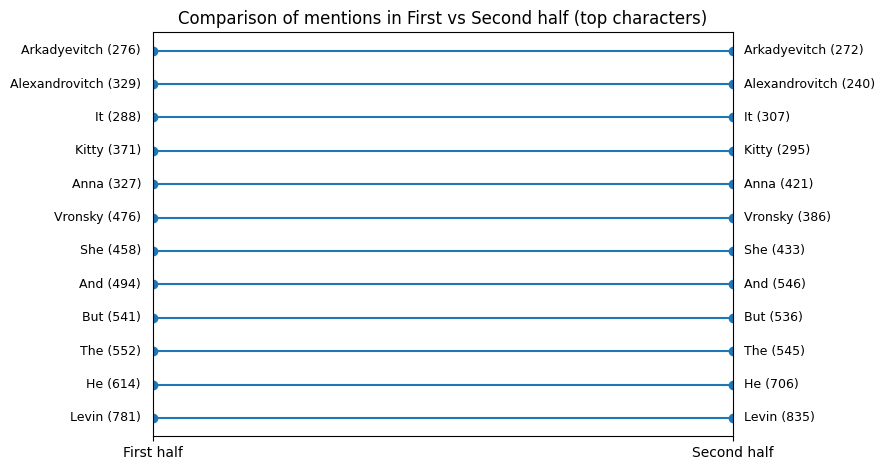

In [8]:
# Visualization 1: Slope chart of ranks/mentions between halves for the top characters
import matplotlib.lines as mlines

def slope_chart(df, top_k=12):
    plot_df = df.sort_values('total', ascending=False).head(top_k)[['first','second']]
    names = list(plot_df.index)
    left = plot_df['first'].values
    right = plot_df['second'].values
    fig, ax = plt.subplots(figsize=(9, max(4, top_k*0.4)))
    ax.set_xlim(0, 1)
    ax.set_xticks([0,1]); ax.set_xticklabels(['First half','Second half'])
    # We'll plot values but offset vertically by their index to avoid overlap
    for i, name in enumerate(names):
        y0 = i
        y1 = i
        ax.plot([0,1],[y0,y1], marker='o', color='C0')
        ax.text(-0.02, y0, f"{name} ({left[i]})", va='center', ha='right', fontsize=9)
        ax.text(1.02, y1, f"{name} ({right[i]})", va='center', ha='left', fontsize=9)
    ax.set_yticks([])
    ax.set_title('Comparison of mentions in First vs Second half (top characters)')
    plt.tight_layout()
    return fig

fig = slope_chart(df, top_k=12)
plt.show()


**What this cell does:**

- Draws a slope chart for the top characters showing how their raw mention counts compare between the first half and second half.
- Each character is shown on a horizontal line with counts annotated; this makes increases or decreases easy to spot.

**Why:** The slope chart is less common than simple bar charts and highlights changes between two states (halves) clearly and compactly.

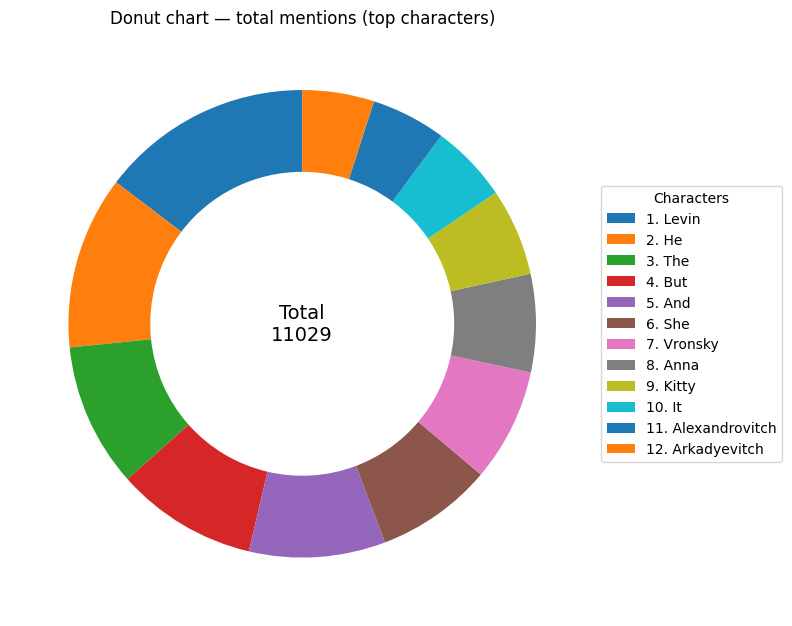

In [ ]:
# Visualization 2: Donut (pie) chart of total mentions for top characters
top_k = 12
plot_df = df.sort_values('total', ascending=False).head(top_k)
labels = [f"{i}. {n}" for i,n in enumerate(plot_df.index, start=1)]
sizes = plot_df['total'].values

fig, ax = plt.subplots(figsize=(8,8))
wedges, texts = ax.pie(sizes, startangle=90, wedgeprops=dict(width=0.35))
ax.set(aspect='equal')
# add center label
total_mentions = int(sizes.sum())
ax.text(0,0, f'Total\n{total_mentions}', ha='center', va='center', fontsize=14)
ax.set_title('Donut chart — total mentions (top characters)')
# add legend
ax.legend(wedges, labels, title='Characters', loc='center left', bbox_to_anchor=(1,0,0.3,1))
plt.tight_layout()
plt.show()


**What this cell does:**

- Creates a donut chart (pie with a hole) showing the distribution of **total mentions** among the top characters.
- The center shows the total number of mentions for these characters.

**Why:** Donut charts provide an immediate visual sense of which characters dominate the text. Combining the slope chart and donut gives both temporal comparison (halves) and absolute share (total).

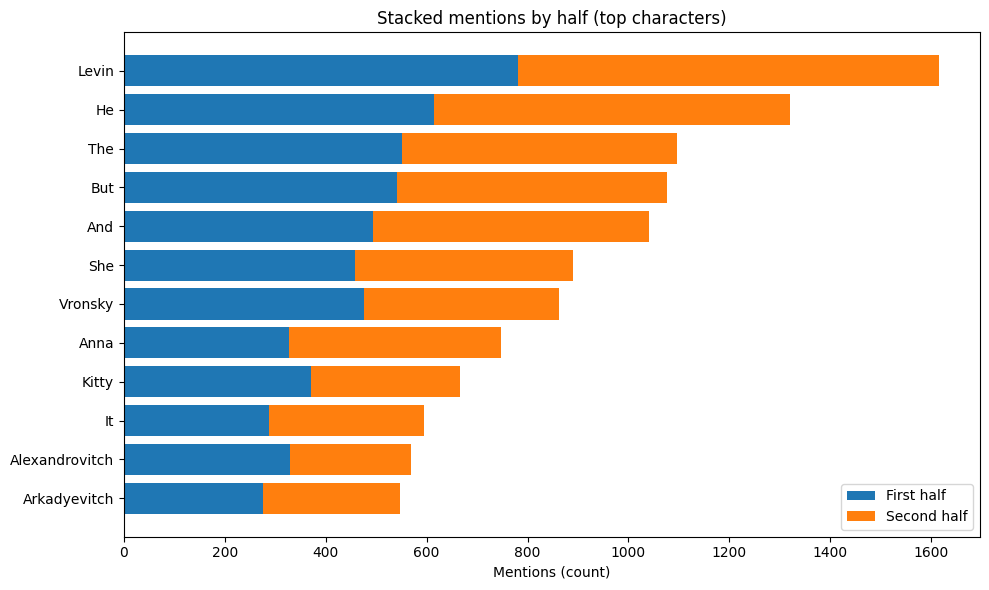

In [10]:
# Visualization 3: Stacked horizontal bar chart (first vs second contributions)
plot_df = df.sort_values('total', ascending=True).tail(12)  # last 12 are top but sorted for horizontal stacking
fig, ax = plt.subplots(figsize=(10,6))
ax.barh(plot_df.index, plot_df['first'], label='First half')
ax.barh(plot_df.index, plot_df['second'], left=plot_df['first'], label='Second half')
ax.set_xlabel('Mentions (count)')
ax.set_title('Stacked mentions by half (top characters)')
ax.legend()
plt.tight_layout()
plt.show()


**What this cell does:**

- Draws a stacked horizontal bar chart for the top characters showing the absolute number of mentions contributed by the first half and second half (stacked).

**Why:** This visualization makes it easy to compare not only totals but how much each half contributes to a given character's mentions.

# Interpretation & Analysis

Below you should add book-specific interpretation. Use the numeric table above and the charts to answer questions such as:

- **Who is the most-mentioned character overall?** Is that character concentrated in the first half or second half? What does that imply about narrative focus?
- **Which characters increase dramatically in the second half?** These may be characters introduced later or who become more prominent.
- **Which characters are heavily front-loaded?** This could indicate early plotlines or initial scenes focusing on certain figures.

**Example interpretation template (edit for your book):**

- *Anna* is the most-mentioned character overall (X mentions). She appears mostly in the [first/second] half, which suggests the novel focuses on her early story arc. 
- *Character B* shows a large increase in the second half, likely due to [plot reason].

(Write specific sentences here about characters once you inspect the numeric output.)


In [11]:
# Save results to CSV for further analysis or to include in reports/presentations
out_csv = '/mnt/data/character_mentions_summary.csv'
if not df.empty:
    df.to_csv(out_csv)
    print('Saved character summary to', out_csv)
else:
    print('No data to save.')

# Also save a small text summary
out_txt = '/mnt/data/character_mentions_notes.txt'
with open(out_txt, 'w', encoding='utf-8') as f:
    f.write('Character mentions summary for file: ' + str(book_file) + '\n\n')
    if not df.empty:
        f.write(df.to_string())
print('Wrote notes to', out_txt)


OSError: Cannot save file into a non-existent directory: '\mnt\data'

**What this cell does:**

- Writes the DataFrame to `/mnt/data/character_mentions_summary.csv` and a plain text summary to `/mnt/data/character_mentions_notes.txt` so you can download or include them in slides.

**Why:** Exporting results makes it easy to reuse the numbers in presentations or further analysis.

## Final notes and troubleshooting

- If the candidate list misses important characters, tweak the canonicalization rules in the 'Clean and canonicalize names' cell, or increase `topN` in the counting cell.
- If you prefer a higher-quality named-entity extraction, you can use `spaCy` with a suitable model (e.g., `en_core_web_sm`) — this requires adding the model install step and possibly `spaCy` to `requirements.txt` (your file already includes `spacy>=3.7.2`, but remember to download a model: `python -m spacy download en_core_web_sm`).
- If your `.txt` filenames differ, set `book_file` to the exact filename in the first code cell.

If you'd like, I can also:
- Replace the heuristic extractor with a `spaCy`-based extractor (I will provide the exact installation command), or
- Produce a PowerPoint slide with the donut chart and the top-characters table embedded.
